# Embeddings

## What are Embeddings?

For similarity comparisons in Deep Learning: Usage of "Embeddings"

What are they?

"An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings make it easier to do machine learning on large inputs like sparse vectors representing words. Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space. An embedding can be learned and reused across models."

For a better understanding let's visualize some embeddings.

### Embeddings Visualization

Popular approach for embedding visualization: T-SNE (t-Distributed Stochastic Neighbor Embedding)

As per SciKitLearn:

- Converts similarities between data points to joint probabilities
- Tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data
- Has a cost function that is not convex, i.e. with different initializations we can get different results
- Highly recommended to use another dimensionality reduction method to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high

Let's use T-SNE to have a look at our original classification embeddings.
To to that, let's recreate the original model and train it on our dataset:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Import the dataset as a pandas DataFrame
ds = pd.read_csv('./dataset/german_sign_language.csv')
ds = ds.sort_values('label')

# Convert the DataFrame to Numpy array for samples and labels
ds_y = ds.label.array
ds_y = pd.factorize(ds_y)[0]
ds_y = np.array(ds_y)
ds_y = to_categorical(ds_y.astype(int))  # labels to categorical
ds_x = ds.drop(['label'], axis=1)
ds_x = ds_x.to_numpy()
ds_x = ds_x.reshape((ds_x.shape[0], -1, 3))  # reshape to 3D landmarks

# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(ds_x, ds_y, test_size=0.2, random_state=42)

/var/folders/cc/r80wblpx1_j0xh5_krnd3pym0000gn/T/ipykernel_3879/184044467.py:12: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ds_y = pd.factorize(ds_y)[0]


In [2]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, AlphaDropout, LayerNormalization

# Model input
inputs = Input(shape=x_train[0].shape, name='Landmark_Vectors')

# Layer normalization (only for inputs)
layerNorm = LayerNormalization(name='LayerNorm')(inputs)

# Flatten 3D inputs
flatten = Flatten(name='Flatten_Vectors')(layerNorm)

# Create conical, fully connected NN with 6 dense layers
dense_count = 6
dense_base = 48
out = flatten

for i in range(dense_count):
    units = (dense_count-i) * (dense_count-i) * dense_base
    dense = Dense(units, 
                  kernel_initializer="lecun_normal", 
                  bias_initializer="zeros", 
                  activation='selu',
                  name=f'Dense_{i+1}')
    a_dropout = AlphaDropout(0.05, name=f'Dropout_{i+1}')
    out = dense(out)
    out = a_dropout(out)

# Output to class vector using softmax activation
outputs = Dense(y_train[0].shape[0], activation='softmax', name='Output_Vector')(out)

model = Model(inputs=inputs, outputs=outputs, name="SNN_6")
model.summary()

Model: "SNN_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Landmark_Vectors (InputLay  [(None, 21, 3)]           0         
 er)                                                             
                                                                 
 LayerNorm (LayerNormalizat  (None, 21, 3)             6         
 ion)                                                            
                                                                 
 Flatten_Vectors (Flatten)   (None, 63)                0         
                                                                 
 Dense_1 (Dense)             (None, 1728)              110592    
                                                                 
 Dropout_1 (AlphaDropout)    (None, 1728)              0         
                                                                 
 Dense_2 (Dense)             (None, 1200)              207480

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate if no improvement is made (after 5 epochs)
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                              factor=0.2,
                              min_lr=0.00001,
                              patience=5,
                              verbose=0)

# Use callback to stop training if no improvement is made (after 10 epochs)
early_stop = EarlyStopping(monitor='val_acc',
                           restore_best_weights=True,
                           patience=10,
                           verbose=0)

In [5]:

from tensorflow.keras.optimizers import Adam

# Use Adam optimizer
adam = Adam(learning_rate=0.001, beta_2=0.99, epsilon=0.01)

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

# Training Hyperparameters
epochs = 10
val_split = .2


# And start training
history = model.fit(x_train, y_train,
                      epochs=100,
                      batch_size=32,
                      validation_split=val_split,
                      callbacks=[early_stop, reduce_lr],
                      verbose=0)

In [7]:
from pathlib import Path

MODEL_DIR = "models"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

# Let's save our trained model
model.save(f"{MODEL_DIR}/original_snn6.keras")

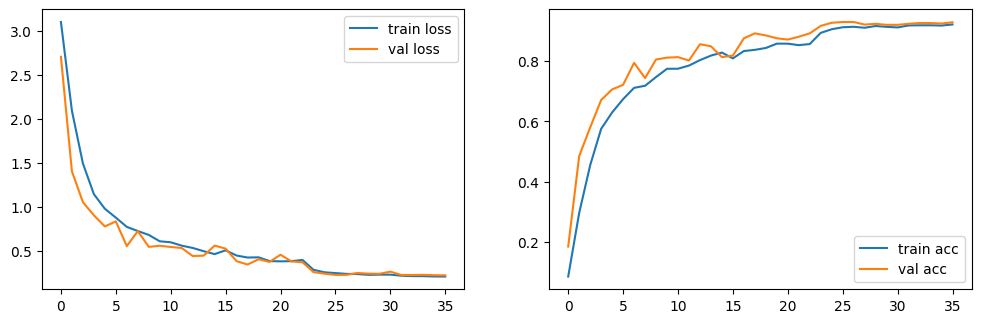

In [8]:
import matplotlib.pyplot as plt

# Lets visualize the training

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()

plt.show()
plt.close()

In [9]:
# And evaluate the model on test data
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f} acc={acc:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.3028 acc=0.9234


That looks similar to our original results.

Now let's visualize the embeddings. For this we'll focus on the model's penultimate layer (called "Dense_6"):

In [54]:
# Get model inputs
snn_input = model.input
# Get embeddings layer
snn_embed = model.get_layer("Dense_6").output

# Create new model that only reaches to embedding layer
embed = Model(inputs=snn_input, outputs=snn_embed)

# And get embeddings for the test data
embeddings = embed.predict(x_test)

46/46 [==============================] - 0s 3ms/step


Luckily the weight dimensions are less than 50, so we can use them with T-SNE straight away:

In [56]:
from sklearn.manifold import TSNE

# Fit T-SNE on embeddings
tsne = TSNE(n_components=3, random_state=42, verbose=1)
reduced_weights = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1462 samples in 0.000s...
[t-SNE] Computed neighbors for 1462 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1462
[t-SNE] Computed conditional probabilities for sample 1462 / 1462
[t-SNE] Mean sigma: 14.060149
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.884411
[t-SNE] KL divergence after 1000 iterations: 0.285560


If we take a look at our embeddings (which are now reduced to 3 dimensions), we can see how embeddings for different categories are separated in space:

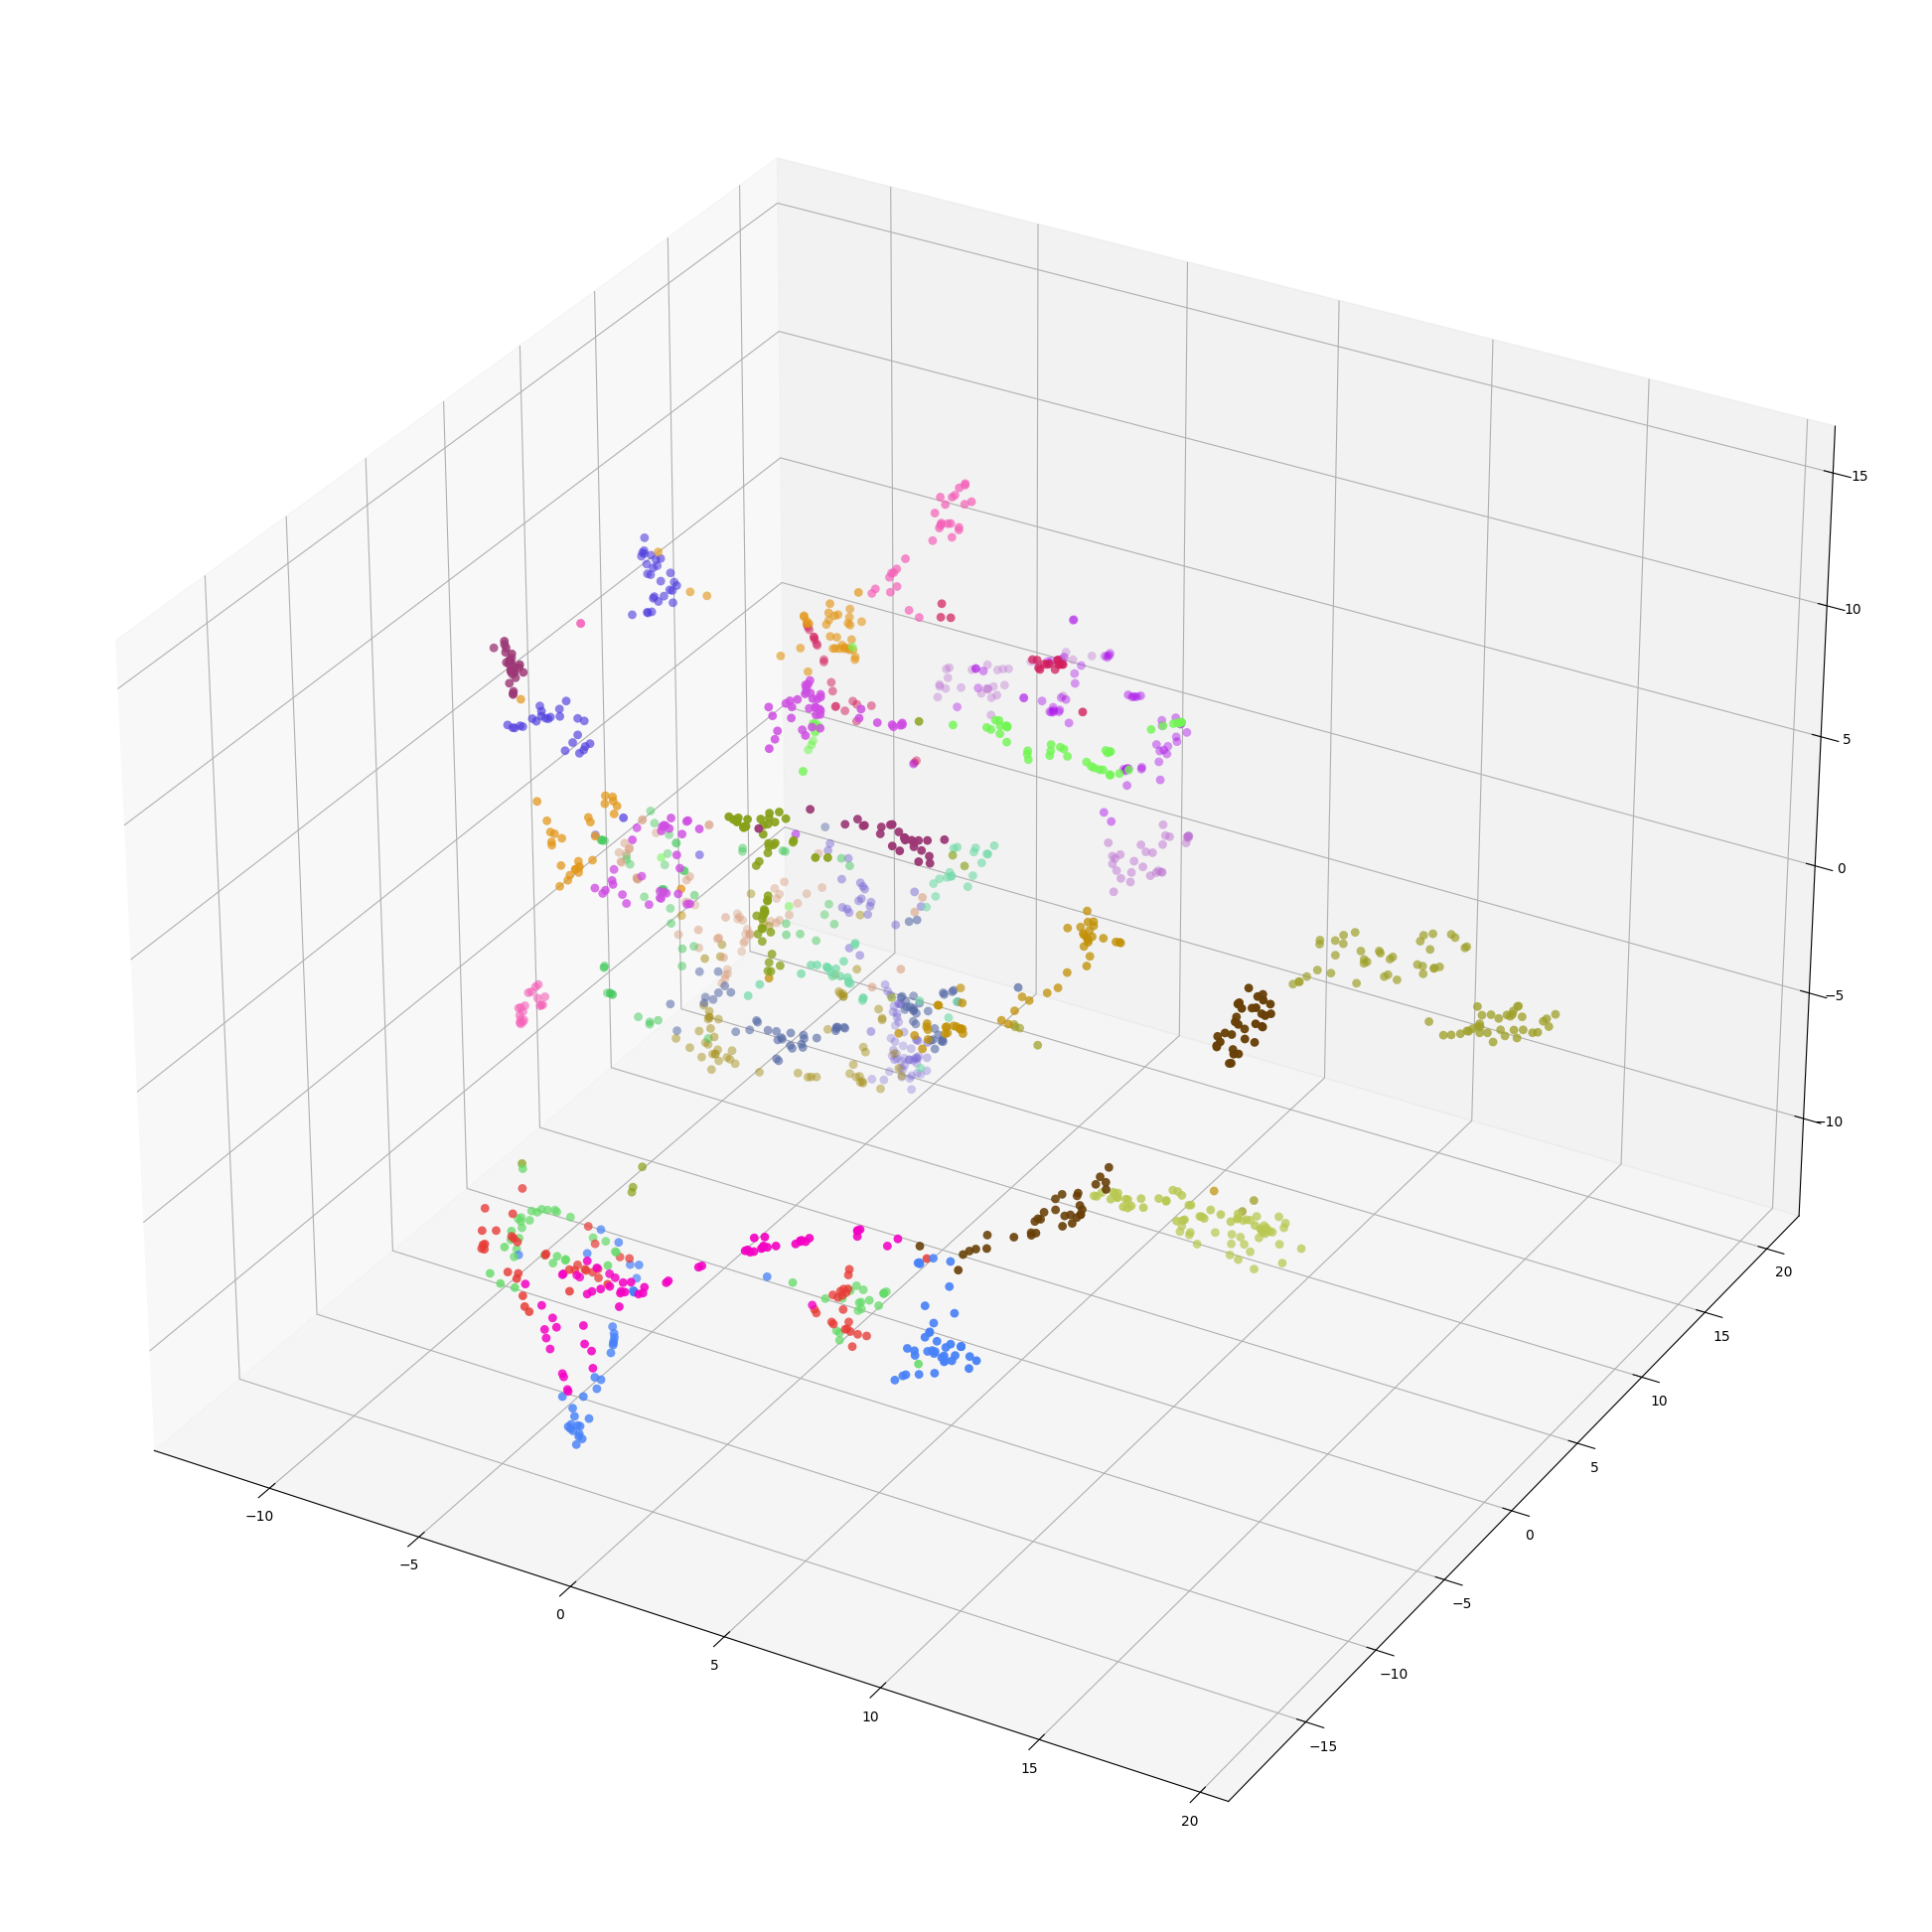

In [57]:
from matplotlib.colors import ListedColormap

# Create a custom color map for each label (= letter)
int_labels = np.argmax(y_test, axis=1)
num_unique_labels = np.unique(int_labels).shape[0]
random_colors = [np.random.rand(3,) for _ in range(num_unique_labels)]
custom_cmap = ListedColormap(random_colors)

# Visualize embeddings in scatter plot
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(reduced_weights[:,0], reduced_weights[:,1], reduced_weights[:,2], lw=0, s=40, c=int_labels, cmap=custom_cmap)

plt.show()
plt.close()